In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline
#%matplotlib widget

In [2]:
import numpy as np
import scipy
import umap
from sklearn.decomposition import PCA
import tqdm

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('bioAI.mplstyle')

import sys
sys.path.append('../') if '../' not in sys.path else None 
from methods import *
from plotting_functions import *

In [3]:
nx,ny = 1,1 # board size
res = 32

# initialize board
xx, yy = np.meshgrid(
    np.linspace(-nx/2, nx/2, res),
    np.linspace(-ny/2, ny/2, res),
)
board = np.stack([xx, yy], axis=-1)

# initialize grid module
T = 1
f = 1/T
orientation_offset = 0
center = np.zeros(2)
#board += center

gridmodule = SquareGridModule(center,orientation_offset,f,non_negative=False,add=True)

In [4]:
phases = gridmodule.inner_square.sample(3,seed=3)
gridmodule.init_module(phases)
ratemaps = gridmodule(board)
phases.shape, ratemaps.shape

((3, 2), (3, 32, 32))

(<Figure size 300x300 with 1 Axes>, <AxesSubplot:>)

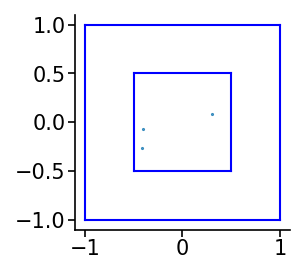

In [5]:
gridmodule.plot(figsize=(2,2))

In [6]:
np.min(ratemaps), np.max(ratemaps)

(0.00025316095115113235, 0.9998563904133564)

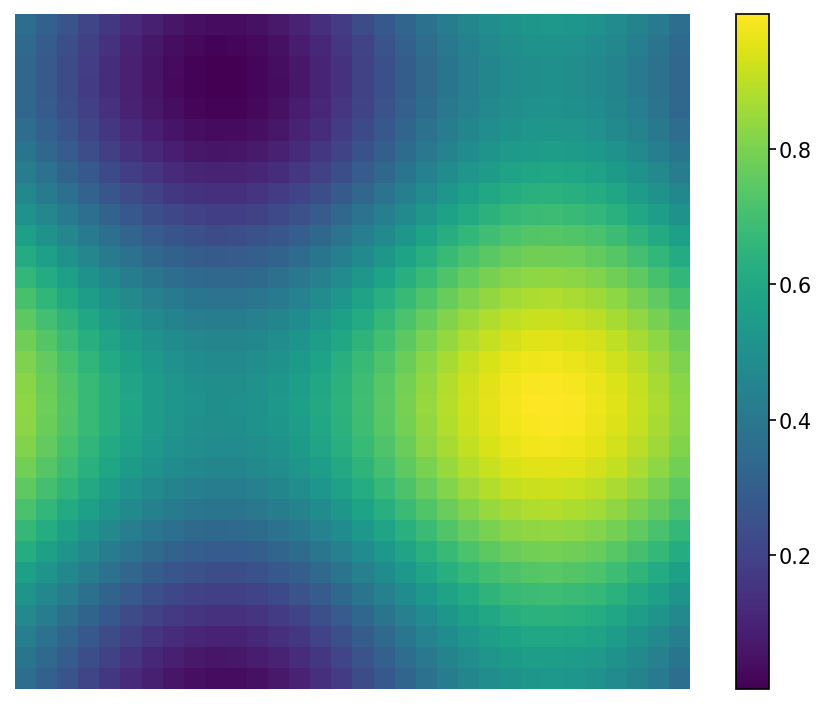

In [7]:
plt.imshow(ratemaps[1])
plt.axis('off')
plt.colorbar()

## Find roots (optimise) of spatial position, given activity

In [8]:
def loss_fn_wrapper(activity, gridmodule):
    # activity: (ncells,)
    def loss_fn(loc):
        return np.sum((gridmodule(loc) - activity)**2)
    return loss_fn

In [9]:
def decode_via_optimisation(activity,gridmodule,x0):
    """
    params:
        activity: (ncells,) grid cells ensemble activity that we want to decode to space 
        gridmodule: Gridmodule object
        x0: initial spatial coordiante to start with (2,)
    """
    loss_fn = loss_fn_wrapper(activity, gridmodule)
    return scipy.optimize.minimize(loss_fn,x0)

In [79]:
def decode_all_activity(gridmodule,x0=np.zeros(2),res=16):
    # initialize board (assume activity range is [0,1]^3
    xx, yy, zz = np.meshgrid(
        np.linspace(0, 1, res),
        np.linspace(0, 1, res),
        np.linspace(0, 1, res),
    )
    activity_board = np.stack([xx, yy, zz], axis=-1)
    
    decoded_pos = np.zeros([res]*3 + [2])
    errors = np.zeros([res]*3)
    for i in tqdm.trange(res**3):
        x,y,z = i//res**2, (i//res)%res, i%res
        tmp = decode_via_optimisation(activity_board[x,y,z],gridmodule,x0)
        decoded_pos[x,y,z] = tmp.x
        errors[x,y,z] = tmp.fun

    T = 1/gridmodule.f
    decoded_pos = ((decoded_pos + 0.5) % T) - 0.5*T
    return decoded_pos, errors

In [80]:
res = 16
# initialize board (assume activity range is [0,1]^3
xx, yy, zz = np.meshgrid(
    np.linspace(0, 1, res),
    np.linspace(0, 1, res),
    np.linspace(0, 1, res),
)
activity_board = np.stack([xx, yy, zz], axis=-1)

In [81]:
decoded_pos, errors = decode_all_activity(gridmodule)

100%|██████████████████████████████████████| 4096/4096 [00:09<00:00, 427.94it/s]


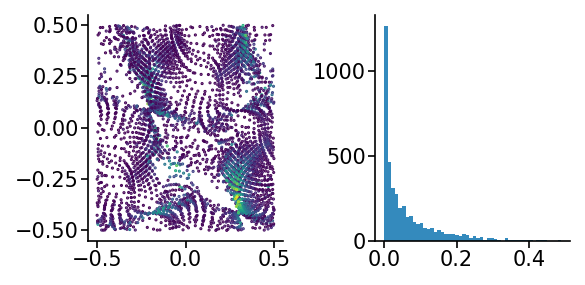

In [106]:
fig,axs=plt.subplots(ncols=2, figsize=(4,2))
axs[0].scatter(*decoded_pos.reshape(-1,2).T,c=errors.flatten())
_=axs[1].hist(errors.flatten(),bins=50)

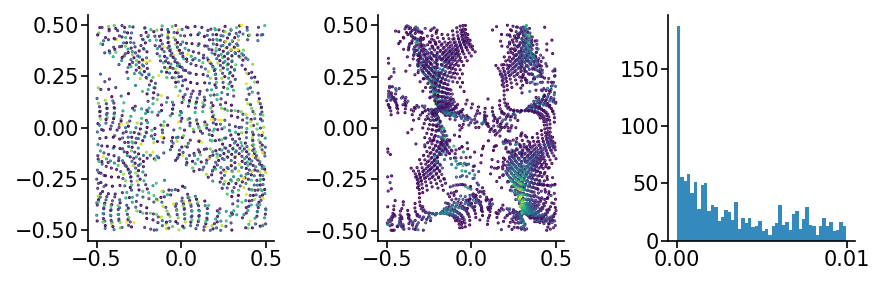

In [123]:
error_mask = errors <= 0.01

fig,axs=plt.subplots(ncols=3, figsize=(6,2))
axs[0].scatter(*decoded_pos[error_mask].reshape(-1,2).T,c=errors[error_mask].flatten())
axs[1].scatter(*decoded_pos[~error_mask].reshape(-1,2).T,c=errors[~error_mask].flatten())
_=axs[2].hist(errors[error_mask].flatten(),bins=50)

100%|██████████████████████████████████████| 4096/4096 [00:09<00:00, 432.09it/s]


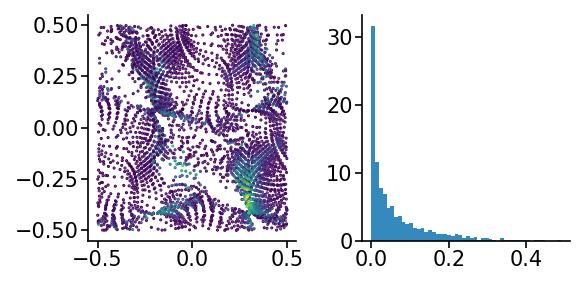

In [93]:
# different initial condition x0
decoded_pos, errors = decode_all_activity(gridmodule,x0=np.array([0.21,0.44]))

fig,axs=plt.subplots(ncols=2, figsize=(4,2))
axs[0].scatter(*decoded_pos.reshape(-1,2).T,c=errors.flatten())
_=axs[1].hist(errors.flatten(),bins=50,density=True)

In [33]:
out = scipy.stats.binned_statistic_2d(*decoded_pos.reshape(-1,2).T,np.empty(res**3), 
                                      statistic='count',bins=32)

In [37]:
np.min(out.statistic), np.max(out.statistic), np.mean(out.statistic), np.median(out.statistic), np.std(out.statistic)

(0.0, 48.0, 4.0, 3.0, 3.9387398841507673)

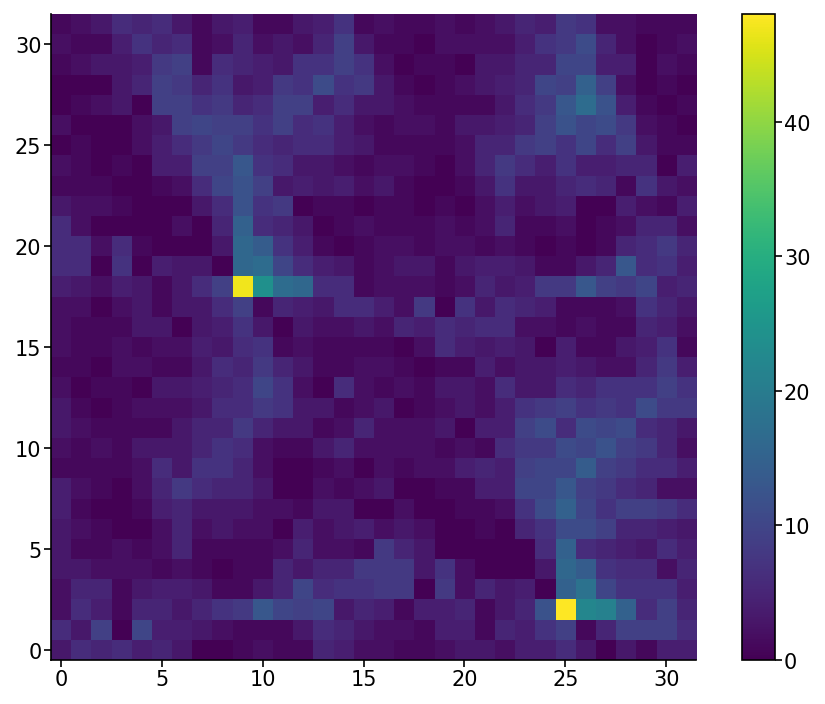

In [41]:
plt.imshow(out.statistic.T,origin='lower')
plt.colorbar()